In [11]:
from PIL import Image
import PIL
import png
import numpy as np
import random
import os
from IPython.display import clear_output
import itertools
from matplotlib.pyplot import imshow


# re-write the stim placement with a two-dimensional Gaussian or whatever Justin Halberda & co use,
# without replacement in space ofc

# https://www.pnas.org/content/pnas/109/28/11116.full.pdf

## Prereg:
## https://docs.google.com/document/d/1luDXWG7kY_0g1hfFBqCm0AS5pfY8Bi7tOVnklFqYBCU/edit

### set up paths, stim list, etc.

In [118]:
proj_dir = os.path.abspath('../..')
stimuli_dir = os.path.join(proj_dir,'stimuli')
data_dir = 'animal_silhouettes'
out_dir = os.path.join(stimuli_dir,'stims')
path_to_stims = os.path.join(stimuli_dir,'stims')

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
if not os.path.exists(path_to_stims):
    os.makedirs(path_to_stims)


animals = sorted(['rabbit','wolf','squirrel','bear','deer','owl'])
animal_paths = ['{}.png'.format(i) for i in animals]


### helper functions

In [119]:
def load_images_from_folder(filename):
    img = Image.open(filename)
    return img

def place_animals(big_backdrop='big_background.png',
                  backdrop='background.png',
                  animal='rabbit',
                  cardinality=1,
                  version=0,
                  padding=30,
                  jitter=20,                  
                  data_dir='animal_silhouettes',
                  out_dir='stims',
                  regular=False,
                  save=True):
    
    '''
    input: 
        big_backdrop = filename, a big black rectangle slightly larger than "backdrop" to provide an outline
        backdrop = filename, a big white rectangle that serves as the main background for animal silhouettes
        animal = str, name of animal
        cardinality = int, how many animals to place on this image
        version = int, which random seed to use? controls spatial distribution of animals on background
        padding = int, how much padding between any edge of image and any stim
        jitter = int, how much jitter to allow away from exact grid placement?
        data_dir = dir to load in animal silhouette source files from
        out_dir = dir to save rendered stims to
    
    output: 
        saves PIL Image file out to out_dir directory, named `image_name`
    '''

    ## generate background images if they don't already exist
    if not os.path.exists(os.path.join(data_dir, 'background.png')):
        frame = 800*[800*[255,255,255,255]]
        big_frame = 810*[810*[0,0,0,255]]
        png.from_array(frame, 'RGBA').save(os.path.join(data_dir, 'background.png'))
        png.from_array(big_frame, 'RGBA').save(os.path.join(data_dir, 'big_background.png'))
    
    ## load in data
    big_background = Image.open(os.path.join(data_dir,big_backdrop))
    background = Image.open(os.path.join(data_dir,backdrop))
    foreground = Image.open(os.path.join(data_dir,'{}.png'.format(animal)))

    ## random seed? use version number to control random seed
    random_seed = version

    ## get whichever dim is longest for animal, width or height
    maxdim_fore = np.max([np.shape(foreground)[0],np.shape(foreground)[1]])
    maxdim_back = np.shape(background)[0] ## get dims of background
    maxdim_back_padded = maxdim_back - padding*2

    
    num_cols = np.int(np.floor(maxdim_back_padded/maxdim_fore)) ## how many animals can we tile in that direction
    ## make sure we have at least as many grid cells as we have cardinalities
    assert num_cols**2 >= cardinality
    
#     ## for if we want animals to be maximally spaced regardless of the cardinality
#     num_cols = np.int(np.ceil(np.sqrt(cardinality)))

    ## lower bound on animal placement in either horiz/vertical dimension
    lb = padding 
    ## upper bound on animal placement
    ub = maxdim_back - padding - maxdim_fore 
    ## grid coordinates along one dimension
    cols = [np.int(i) for i in np.linspace(lb,ub,num = num_cols)]

    ## allowable grid locations to place animal
    legal_locations = np.array([p for p in itertools.product(cols,repeat=2)])
    
    ## randomly sample a subset of these legal locations to be actual stim locations
    
    inds_ra = np.random.RandomState(random_seed).choice(np.arange(len(legal_locations)), size=cardinality, replace=False)
    
    nearest_multiple = num_cols * round(int(np.floor((len(legal_locations)-cardinality)/2)) / num_cols)
    inds_re = np.arange(nearest_multiple,cardinality+nearest_multiple)
#     inds = np.arange(cardinality)
    inds = inds_re if regular == True else inds_ra
    stim_locations = [tuple(i) for i in legal_locations[inds]]

    ## get a bunch of random jitter magnitudes
    jitter_mags = [np.int(i) for i in np.random.RandomState(random_seed).rand(len(stim_locations)*2)*jitter*2 - jitter]

    ## get jittered stim_locations
    jittered_stim_locations = [(tup[0] + jitter_mags[i], 
                                tup[1] + jitter_mags[i*2]) for (i,tup) in enumerate(stim_locations)]

    ## now actually place the animals in those jittered_stim_locations to generate the stims
    for new_coord in jittered_stim_locations:
        background.paste(foreground, new_coord, foreground)

    big_background.paste(background,(5,5),background)

    ## save images as image_name out to out_dir
    regularity = 'regular' if regular == True else 'random'
    image_name = '{}_{}_{}_{}.png'.format(regularity,animal, str(cardinality),str(version).zfill(3))
    
    imshow(np.asarray(big_background))
    if save == True:
        big_background.save(os.path.join(out_dir,image_name))        
    
    


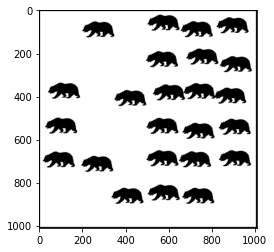

In [120]:
place_animals(big_backdrop='big_background.png',
              backdrop='background.png',
              animal='bear',
              cardinality=24,
              version=1,
              padding=30,
              jitter=20,
              data_dir='animal_silhouettes',
              out_dir=out_dir,
              save=False)    

Done!


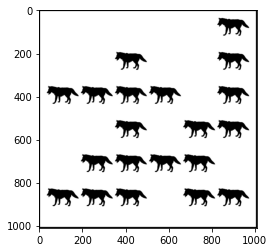

In [121]:
## display params
cardinalities = np.arange(1,21) # np.append(np.arange(1,7),np.arange(15,21))
num_versions = 1

for i,animal in enumerate(animals):
    for num in cardinalities:
        for v in np.arange(num_versions):
            print('generating animal: {} | cardinality: {} | version: {}'.format(animal, num, v))
            clear_output(wait=True)
            place_animals(big_backdrop='big_background.png',
                          backdrop='background.png',
                          animal=animal,
                          cardinality=num,
                          version=v,
                          padding=30,
                          jitter=0,                  
                          data_dir='animal_silhouettes',
                          out_dir=out_dir,
                          regular=False)        
print('Done!')

In [5]:
blah = 500*[500*[255,255,255,255]]
png.from_array(blah, 'RGBA').save(os.path.join(data_dir, 'blah.png'))